Starting off by importing libraries and the datasets.
I included the comment on library purpose to the side like I saw in a kernel because it helps me keep them straight in my head as I work, and just helped me understand them better. 

In [5]:
import pandas as pd # data processing
import numpy as np # numeric computation
import matplotlib.pyplot as plt # plot visualization
%matplotlib inline
import seaborn as sns # data visualization
import missingno as msno # missing data visualizations and utilities
    #found missingno on a kernel and decided to try it out. 

In [234]:
traindata= pd.read_csv("C:/Users/Izzy/Desktop/213R/HW2/train.csv")
testdata= pd.read_csv("C:/Users/Izzy/Desktop/213R/HW2/test.csv")
traindata.drop(columns = 'Id', inplace=True)

Looked at the data for a bit here, but also checked it out manually in the csv and became familiar with the data description file.

(Realized much later in analysis that the Id column was tripping me up, and made that fix above)

In [235]:
traindata.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [236]:
traindata.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


In [237]:
traindata.select_dtypes(np.number).corr().style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'))

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.0,-0.39,-0.14,0.033,-0.059,0.028,0.041,0.023,-0.07,-0.066,-0.14,-0.24,-0.25,0.31,0.046,0.075,0.0035,-0.0023,0.13,0.18,-0.023,0.28,0.04,-0.046,0.085,-0.04,-0.099,-0.013,-0.0061,-0.012,-0.044,-0.026,0.0083,-0.0077,-0.014,-0.021,-0.084
LotFrontage,-0.39,1.0,0.43,0.25,-0.059,0.12,0.089,0.19,0.23,0.05,0.13,0.39,0.46,0.08,0.038,0.4,0.1,-0.0072,0.2,0.054,0.26,-0.0061,0.35,0.27,0.07,0.29,0.34,0.089,0.15,0.011,0.07,0.041,0.21,0.0034,0.011,0.0074,0.35
LotArea,-0.14,0.43,1.0,0.11,-0.0056,0.014,0.014,0.1,0.21,0.11,-0.0026,0.26,0.3,0.051,0.0048,0.26,0.16,0.048,0.13,0.014,0.12,-0.018,0.19,0.27,-0.025,0.15,0.18,0.17,0.085,-0.018,0.02,0.043,0.078,0.038,0.0012,-0.014,0.26
OverallQual,0.033,0.25,0.11,1.0,-0.092,0.57,0.55,0.41,0.24,-0.059,0.31,0.54,0.48,0.3,-0.03,0.59,0.11,-0.04,0.55,0.27,0.1,-0.18,0.43,0.4,0.55,0.6,0.56,0.24,0.31,-0.11,0.03,0.065,0.065,-0.031,0.071,-0.027,0.79
OverallCond,-0.059,-0.059,-0.0056,-0.092,1.0,-0.38,0.074,-0.13,-0.046,0.04,-0.14,-0.17,-0.14,0.029,0.025,-0.08,-0.055,0.12,-0.19,-0.061,0.013,-0.087,-0.058,-0.024,-0.32,-0.19,-0.15,-0.0033,-0.033,0.07,0.026,0.055,-0.002,0.069,-0.0035,0.044,-0.078
YearBuilt,0.028,0.12,0.014,0.57,-0.38,1.0,0.59,0.32,0.25,-0.049,0.15,0.39,0.28,0.01,-0.18,0.2,0.19,-0.038,0.47,0.24,-0.071,-0.17,0.096,0.15,0.83,0.54,0.48,0.22,0.19,-0.39,0.031,-0.05,0.0049,-0.034,0.012,-0.014,0.52
YearRemodAdd,0.041,0.089,0.014,0.55,0.074,0.59,1.0,0.18,0.13,-0.068,0.18,0.29,0.24,0.14,-0.062,0.29,0.12,-0.012,0.44,0.18,-0.041,-0.15,0.19,0.11,0.64,0.42,0.37,0.21,0.23,-0.19,0.045,-0.039,0.0058,-0.01,0.021,0.036,0.51
MasVnrArea,0.023,0.19,0.1,0.41,-0.13,0.32,0.18,1.0,0.26,-0.072,0.11,0.36,0.34,0.17,-0.069,0.39,0.085,0.027,0.28,0.2,0.1,-0.038,0.28,0.25,0.25,0.36,0.37,0.16,0.13,-0.11,0.019,0.061,0.012,-0.03,-0.006,-0.0082,0.48
BsmtFinSF1,-0.07,0.23,0.21,0.24,-0.046,0.25,0.13,0.26,1.0,-0.05,-0.5,0.52,0.45,-0.14,-0.065,0.21,0.65,0.067,0.059,0.0043,-0.11,-0.081,0.044,0.26,0.15,0.22,0.3,0.2,0.11,-0.1,0.026,0.062,0.14,0.0036,-0.016,0.014,0.39
BsmtFinSF2,-0.066,0.05,0.11,-0.059,0.04,-0.049,-0.068,-0.072,-0.05,1.0,-0.21,0.1,0.097,-0.099,0.015,-0.0096,0.16,0.071,-0.076,-0.032,-0.016,-0.041,-0.035,0.047,-0.088,-0.038,-0.018,0.068,0.0031,0.037,-0.03,0.089,0.042,0.0049,-0.015,0.032,-0.011


# maybe don't include fireplaces at first because missing data problem, but include for second round of evaluation to see if it improves?

Just from looking at the visual representations of the strength of correlations, some key variables jump out as being useful in the model.  For instance, overall quality, lot frontage, year built or remodeled, masonry veneer sq footage, size of a finished basement, sq footage of the house in general (whether first, second floor, or greatroom, bathrooms, rooms above ground, fireplaces, garage size, garage year built.  

While some of those seem to be suffering from some degree of multicollinearity- such as the year garage built and year house built, the various measures of garage size, and possible number of rooms above ground and other measures of square footage, we're left with a good amount of variables to start with. 

I performed a couple of quick checks on some of these, like if the lot size effect was obscured incorrectly by lot frontage, as seen below. 


To see the correlations more clearly, though less visually appealing, I created this list. 

In [238]:
correlation = traindata.select_dtypes(include=[np.number]).corr()
print(correlation['SalePrice'].sort_values(ascending = False))

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


After comparing this list with the graphic above to check again for possible multicollinearity, I decided to incoporate the following variables into my model: SalePrice, OverallQual, GrLivArea, GarageArea, TotalBsmtSF, 1stFlrSF, FullBath, TotRmsAbvGrd, YearBuilt, YearRemodAdd, MasVnrArea, Fireplaces, BsmtFinSF1, LotFrontage, WoodDeckSF, 2ndFlrSF, OpenPorchSF, HalfBath, and LotArea.    
Accordingly, I set those aside in their own little frame

In [239]:
round1 = traindata[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'HalfBath','LotArea']].copy()
round1.head()

,SalePrice,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,MasVnrArea,Fireplaces,BsmtFinSF1,LotFrontage,WoodDeckSF,2ndFlrSF,OpenPorchSF,HalfBath,LotArea
0,208500,7,1710,548,856,856,2,8,2003,2003,196.0,0,706,65.0,0,854,61,1,8450
1,181500,6,1262,460,1262,1262,2,6,1976,1976,0.0,1,978,80.0,298,0,0,0,9600
2,223500,7,1786,608,920,920,2,6,2001,2002,162.0,1,486,68.0,0,866,42,1,11250
3,140000,7,1717,642,756,961,1,7,1915,1970,0.0,1,216,60.0,0,756,35,0,9550
4,250000,8,2198,836,1145,1145,2,9,2000,2000,350.0,1,655,84.0,192,1053,84,1,14260


Using that more limited dataframe, I'm now going to take a look at some factors that might trip up the analysis, such as missing data. 

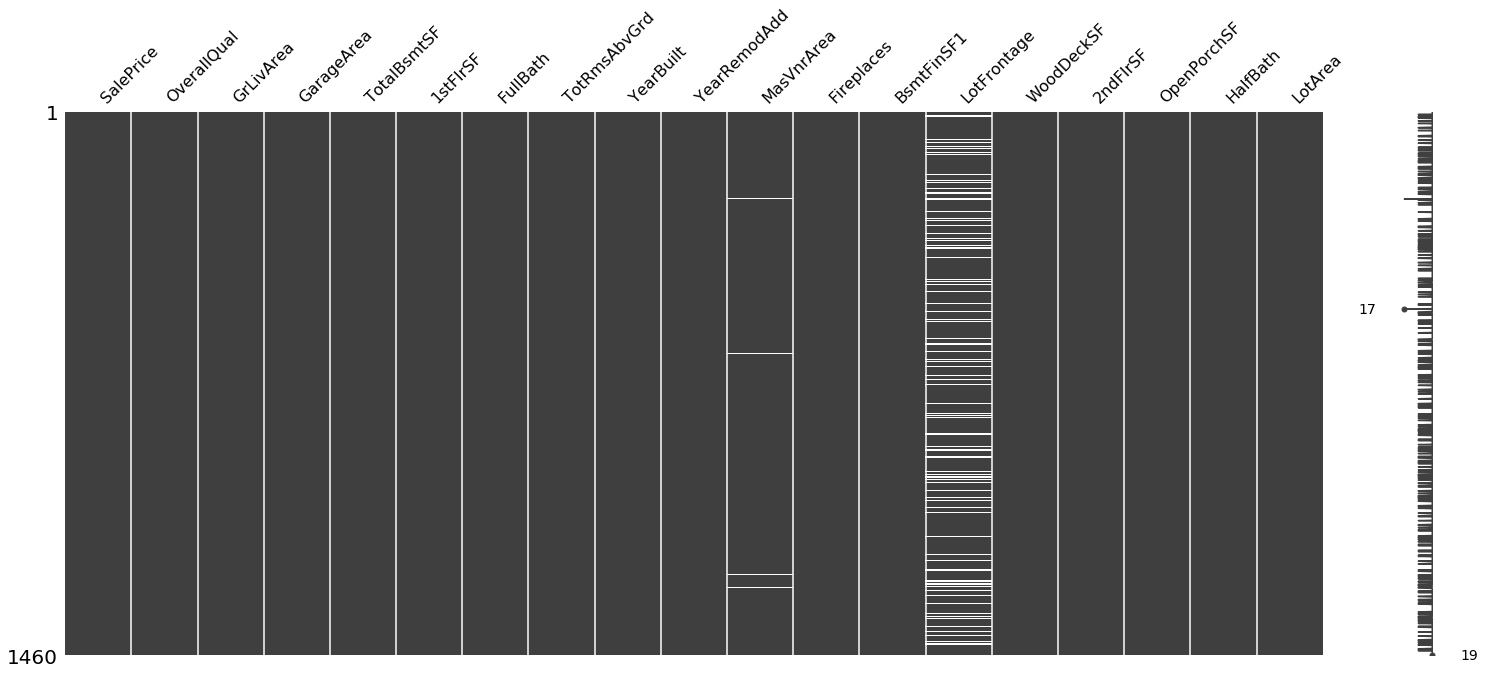

In [240]:
msno.matrix(round1)

While the above visual was a cool way of viewing missing data, I realized that I wanted data on missing inputs in a more digestable format, so I summed the total missing values for each below. 

In [241]:
sumMissing = round1.isnull().sum()
#sumMissingtest = testdata.isnull().sum()
#sumMissingall = sumMissing
#sumMissingall += sumMissingtest
sumMissing.sort_values(ascending = False)


LotFrontage     259
MasVnrArea        8
LotArea           0
TotRmsAbvGrd      0
OverallQual       0
GrLivArea         0
GarageArea        0
TotalBsmtSF       0
1stFlrSF          0
FullBath          0
YearRemodAdd      0
YearBuilt         0
HalfBath          0
Fireplaces        0
BsmtFinSF1        0
WoodDeckSF        0
2ndFlrSF          0
OpenPorchSF       0
SalePrice         0
dtype: int64

Thankfully, there is very little missing data apart from in LotFrontage. My first thought was of the k nearest neighbors strategy we'd just learned, and how that would be fantastic to impute the missing variables. Although I found a module that had that function, a bug in either its or my system kept it from downloading. Instead, I went with the simple imputation from the median value. 

In [28]:
##import fancyimpute
##from fancyimpute import KNN  This is how I'd like to impute missing data, via k nearest neighbors, If I can get the download to work. 

In [242]:
round1['LotFrontage'].fillna((round1['LotFrontage'].median()), inplace=True)
round1['MasVnrArea'].fillna((round1['MasVnrArea'].median()), inplace=True)

In [243]:
sumMissing = round1.isnull().sum()
sumMissing.sort_values(ascending = False)


LotArea         0
YearBuilt       0
OverallQual     0
GrLivArea       0
GarageArea      0
TotalBsmtSF     0
1stFlrSF        0
FullBath        0
TotRmsAbvGrd    0
YearRemodAdd    0
HalfBath        0
MasVnrArea      0
Fireplaces      0
BsmtFinSF1      0
LotFrontage     0
WoodDeckSF      0
2ndFlrSF        0
OpenPorchSF     0
SalePrice       0
dtype: int64

Wohoo! Missing data all filled.  Time to look for outliers. 

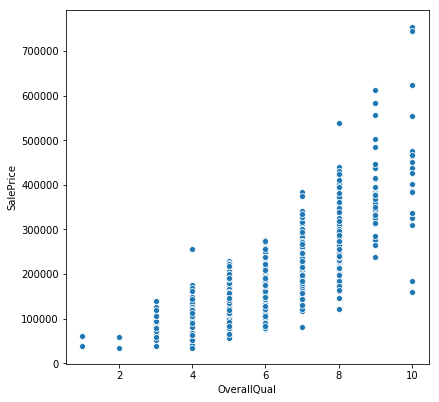

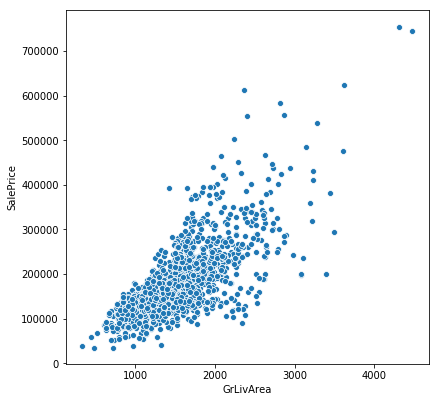

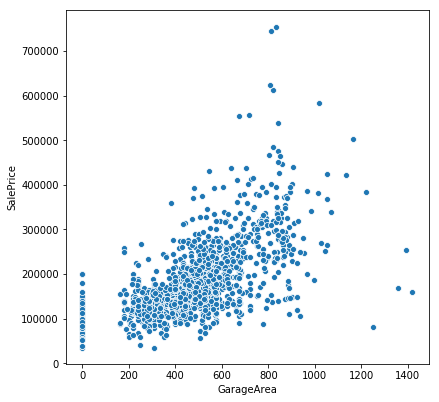

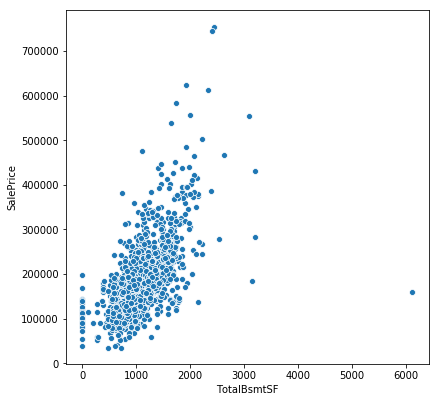

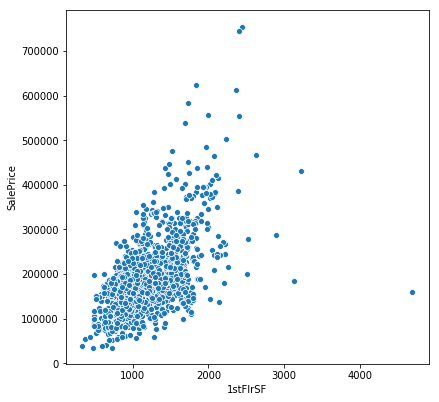

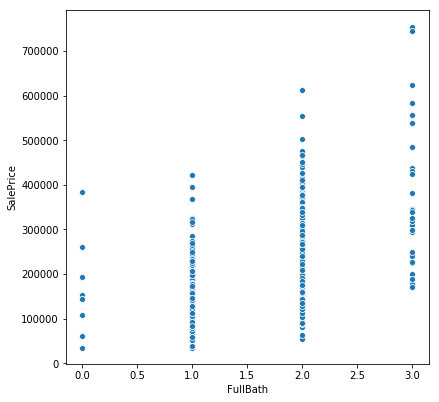

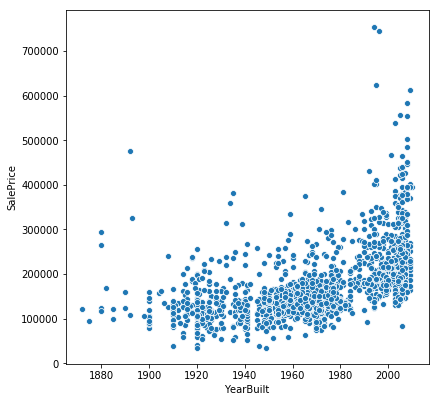

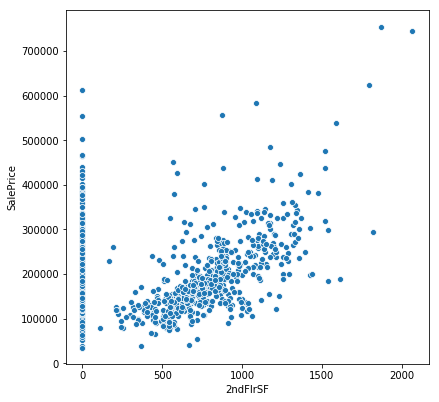

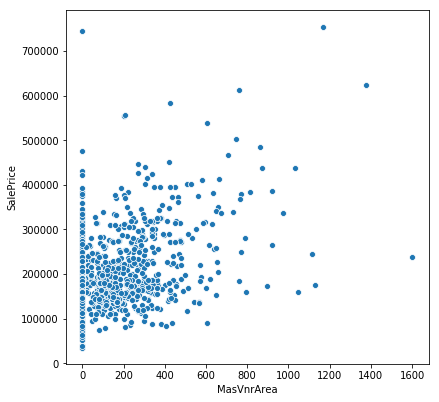

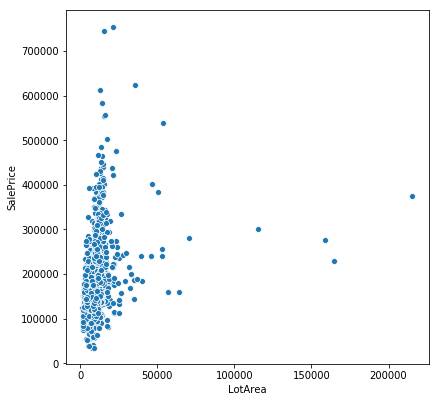

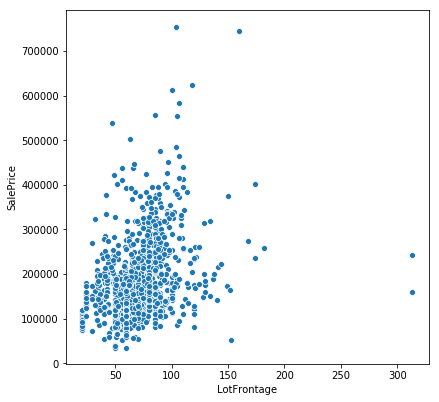

In [78]:
fig, ax = plt.subplots(figsize=(6.5,6.5))
sns.scatterplot(x=round1["OverallQual"], y=round1["SalePrice"], x_jitter=1)
fig, ax = plt.subplots(figsize=(6.5,6.5))
sns.scatterplot(x=round1["GrLivArea"], y=round1["SalePrice"], x_jitter=1)
fig, ax = plt.subplots(figsize=(6.5,6.5))
sns.scatterplot(x=round1["GarageArea"], y=round1["SalePrice"], x_jitter=1)
fig, ax = plt.subplots(figsize=(6.5,6.5))
sns.scatterplot(x=round1["TotalBsmtSF"], y=round1["SalePrice"], x_jitter=1)
fig, ax = plt.subplots(figsize=(6.5,6.5))
sns.scatterplot(x=round1["1stFlrSF"], y=round1["SalePrice"], x_jitter=1)
fig, ax = plt.subplots(figsize=(6.5,6.5))
sns.scatterplot(x=round1["FullBath"], y=round1["SalePrice"], x_jitter=1)
fig, ax = plt.subplots(figsize=(6.5,6.5))
sns.scatterplot(x=round1["YearBuilt"], y=round1["SalePrice"], x_jitter=1)
fig, ax = plt.subplots(figsize=(6.5,6.5))
sns.scatterplot(x=round1["2ndFlrSF"], y=round1["SalePrice"], x_jitter=1)
fig, ax = plt.subplots(figsize=(6.5,6.5))
sns.scatterplot(x=round1["MasVnrArea"], y=round1["SalePrice"], x_jitter=1)
fig, ax = plt.subplots(figsize=(6.5,6.5))
sns.scatterplot(x=round1["LotArea"], y=round1["SalePrice"], x_jitter=1)
fig, ax = plt.subplots(figsize=(6.5,6.5))
sns.scatterplot(x=round1["LotFrontage"], y=round1["SalePrice"], x_jitter=1)

In [90]:
round1["GrLivArea"] = np.where((round1["GrLivArea"] >4500) & (round1["SalePrice"] <250000), round1["GrLivArea"].median(),round1['GrLivArea'])
round1["TotalBsmtSF"] = np.where((round1["TotalBsmtSF"] >4500), round1["TotalBsmtSF"].median(),round1['TotalBsmtSF'])
round1["1stFlrSF"] = np.where((round1["1stFlrSF"] >4000), round1["1stFlrSF"].median(),round1["1stFlrSF"])
round1["SalePrice"] = np.where((round1["SalePrice"] >400000) & (round1["YearBuilt"] <1900), round1["SalePrice"].median(),round1['SalePrice'])
round1["SalePrice"] = np.where((round1["SalePrice"] >700000), round1["SalePrice"].median(),round1['SalePrice'])
round1["MasVnrArea"] = np.where((round1["MasVnrArea"] >1200), round1["MasVnrArea"].median(),round1['MasVnrArea'])
round1["LotArea"] = np.where((round1["LotArea"] >100000), round1["LotArea"].median(),round1['LotArea'])
round1["LotFrontage"] = np.where((round1["LotFrontage"] >250), round1["LotFrontage"].median(),round1['LotFrontage'])

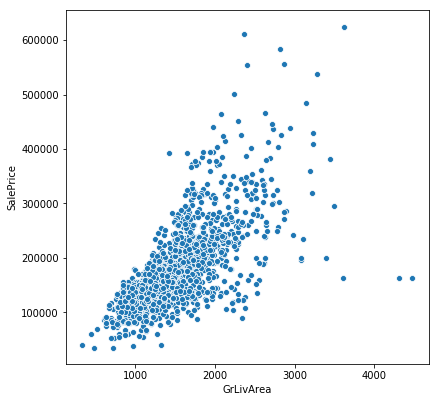

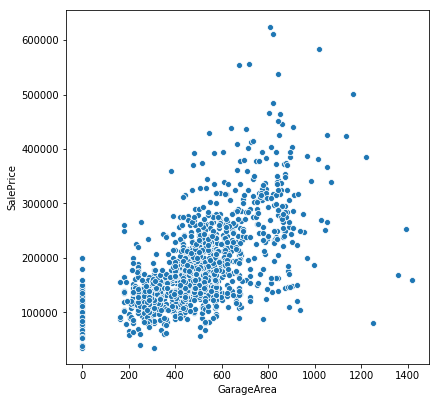

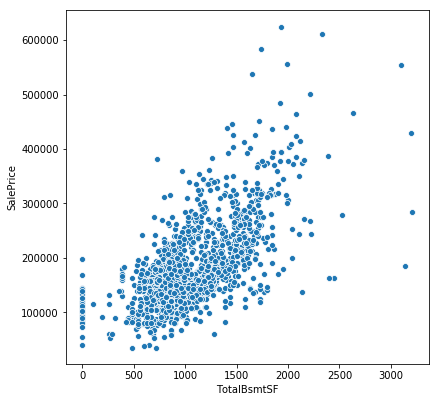

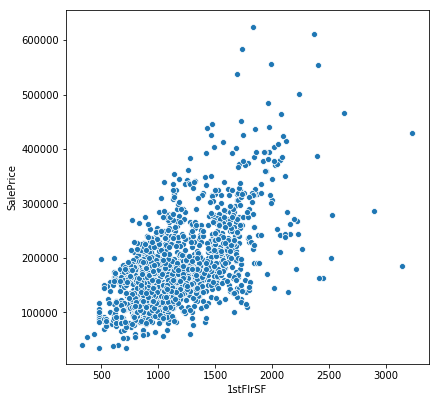

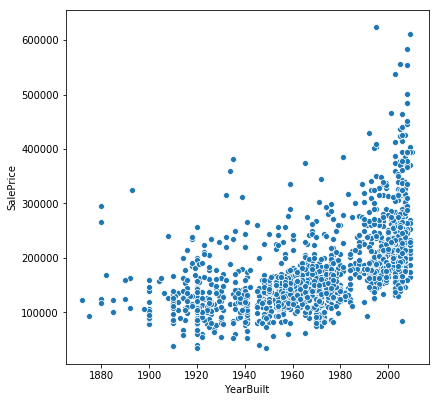

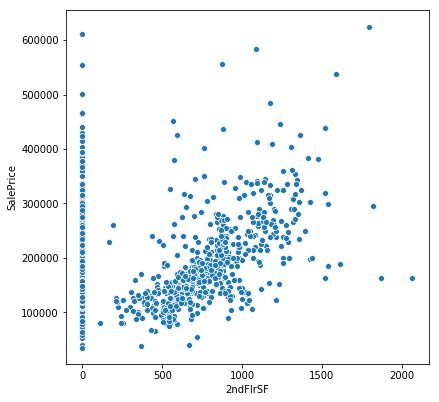

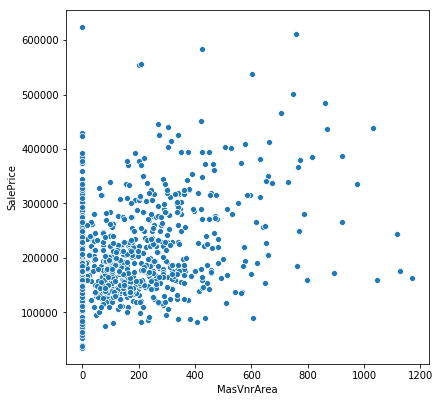

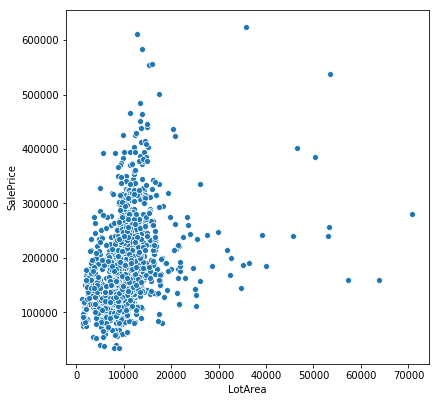

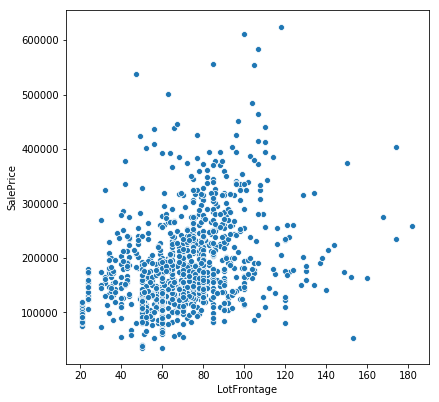

In [93]:
fig, ax = plt.subplots(figsize=(6.5,6.5))
sns.scatterplot(x=round1["GrLivArea"], y=round1["SalePrice"], x_jitter=1)
fig, ax = plt.subplots(figsize=(6.5,6.5))
sns.scatterplot(x=round1["GarageArea"], y=round1["SalePrice"], x_jitter=1)
fig, ax = plt.subplots(figsize=(6.5,6.5))
sns.scatterplot(x=round1["TotalBsmtSF"], y=round1["SalePrice"], x_jitter=1)
fig, ax = plt.subplots(figsize=(6.5,6.5))
sns.scatterplot(x=round1["1stFlrSF"], y=round1["SalePrice"], x_jitter=1)
fig, ax = plt.subplots(figsize=(6.5,6.5))
sns.scatterplot(x=round1["YearBuilt"], y=round1["SalePrice"], x_jitter=1)
fig, ax = plt.subplots(figsize=(6.5,6.5))
sns.scatterplot(x=round1["2ndFlrSF"], y=round1["SalePrice"], x_jitter=1)
fig, ax = plt.subplots(figsize=(6.5,6.5))
sns.scatterplot(x=round1["MasVnrArea"], y=round1["SalePrice"], x_jitter=1)
fig, ax = plt.subplots(figsize=(6.5,6.5))
sns.scatterplot(x=round1["LotArea"], y=round1["SalePrice"], x_jitter=1)
fig, ax = plt.subplots(figsize=(6.5,6.5))
sns.scatterplot(x=round1["LotFrontage"], y=round1["SalePrice"], x_jitter=1)

After examining the graphs, normalizing a few prominent outliers, and rechecking the graphs, things look more centralized to trend. 

With that done, I moved into training my data and preparing for prediction. Just below I scaled the data, dropped the y column, and predicted and displayed the approximate coefficients for each feature.

In [244]:
round1 = round1.copy()

In [293]:
from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler()
round1scaled = robust_scaler.fit(round1).transform(round1)

In [339]:
round1.drop(columns = 'SalePrice', inplace=True)

In [295]:
targettrain = np.log(traindata["SalePrice"])

In [357]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
linear_regression_model = SGDRegressor(tol=.0001, eta0=.01)
linear_regression_model.fit(round1scaled, targettrain)
predictions = linear_regression_model.predict(round1scaled)
mse = mean_squared_error(targettrain, predictions)
print("RMSE: {}".format(np.sqrt(mse)))

RMSE: 0.23879167835261716


In [358]:
sorted(list(zip(round1.columns, linear_regression_model.coef_)), key=lambda x: abs(x[1]))

[('Fireplaces', -0.0029735834710164053),
 ('LotArea', -0.00568791453307271),
 ('OpenPorchSF', 0.006804574060530863),
 ('MasVnrArea', -0.011424070699523739),
 ('TotalBsmtSF', -0.012210357889829241),
 ('LotFrontage', -0.013359234962711818),
 ('BsmtFinSF1', 0.014565411906825459),
 ('GarageArea', 0.023254418067761483),
 ('WoodDeckSF', 0.036775359789679794),
 ('YearRemodAdd', 0.0407557279482661),
 ('TotRmsAbvGrd', 0.05031658806261274),
 ('HalfBath', -0.08466717251368736),
 ('YearBuilt', 0.1656928415424928),
 ('FullBath', -0.2119237731640063),
 ('OverallQual', 0.22592774039618743),
 ('1stFlrSF', 1.6582864609991652),
 ('GrLivArea', -1.8470703974481213),
 ('2ndFlrSF', 2.3678176988442523)]

In [359]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(round1scaled, targettrain, test_size=0.33, random_state=30)

In [360]:
linear_regression_model = SGDRegressor(tol=.0001, eta0=.05,)
linear_regression_model.fit(X_train, y_train)
train_predictions = linear_regression_model.predict(X_train)
test_predictions = linear_regression_model.predict(X_test)

train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))

Train MSE: 0.06963724710466741
Test MSE: 0.049847702018683285


In [361]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(mean_squared_error))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Izzy\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

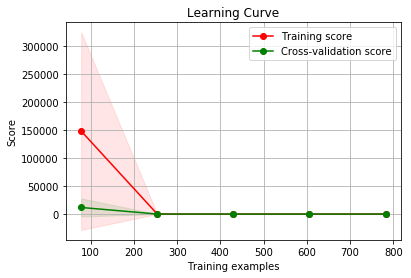

In [362]:
plot_learning_curve(linear_regression_model, "Learning Curve", X_train, y_train, cv=5)

After adjusting the learning rate on the original model (which I definitely lifted from Tyler's lecutre.  I understand the concept, but don't feel confident in recreating the whole process from scratch) I feel okay to move forward to tuning the parameters.  From that process I saw that there may be some overfitting in the model, and possibly some consistent bias (demonstrated by those flattening lines), so I may go back and tune that up later. 

But for now, I'm going to move on to modeling and predicting. 
First, will obtain suggested parameters. . .

In [314]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {"eta0": [ .001, .003, .01, .03, .05, .1, .3, 1, 3]}

linear_regression_model = SGDRegressor(tol=.0001)

n_iter_search = 8
random_search = RandomizedSearchCV(linear_regression_model, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, scoring='neg_mean_squared_error')
random_search.fit(X_train, y_train)

print("Best Parameters: {}".format(random_search.best_params_))
print("Best Negative MSE: {}".format(random_search.best_score_))

Best Parameters: {'eta0': 0.01}
Best Negative MSE: -0.08637481405187421


Hey! Turns out I didn't quite guess the best learning rate, but that's okay!

So now I'm going to plug in those parameters and go ahead and run my model on the test data and see how it fares. 
Starting by producing the scaled test data and cleaning it up the same way that I did the train data. . .

In [323]:
testdata1 = testdata[[ 'OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'HalfBath','LotArea']].copy()
sumMissingtest = testdata1.isnull().sum()
sumMissingtest.sort_values(ascending = False)

LotFrontage     227
MasVnrArea       15
GarageArea        1
TotalBsmtSF       1
BsmtFinSF1        1
LotArea           0
TotRmsAbvGrd      0
GrLivArea         0
1stFlrSF          0
FullBath          0
YearRemodAdd      0
YearBuilt         0
HalfBath          0
Fireplaces        0
WoodDeckSF        0
2ndFlrSF          0
OpenPorchSF       0
OverallQual       0
dtype: int64

In [324]:
testdata1['LotFrontage'].fillna((testdata1['LotFrontage'].median()), inplace=True)
testdata1['MasVnrArea'].fillna((testdata1['MasVnrArea'].median()), inplace=True)
testdata1['GarageArea'].fillna((testdata1['GarageArea'].median()), inplace=True)
testdata1['BsmtFinSF1'].fillna((testdata1['BsmtFinSF1'].median()), inplace=True)
testdata1['TotalBsmtSF'].fillna((testdata1['TotalBsmtSF'].median()), inplace=True)

In [325]:
sumMissingtest = testdata1.isnull().sum()
sumMissingtest.sort_values(ascending = False)

LotArea         0
HalfBath        0
GrLivArea       0
GarageArea      0
TotalBsmtSF     0
1stFlrSF        0
FullBath        0
TotRmsAbvGrd    0
YearBuilt       0
YearRemodAdd    0
MasVnrArea      0
Fireplaces      0
BsmtFinSF1      0
LotFrontage     0
WoodDeckSF      0
2ndFlrSF        0
OpenPorchSF     0
OverallQual     0
dtype: int64

And here we go, the model is ready to run!

In [326]:
from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler()
test1scaled = robust_scaler.fit(testdata1).transform(testdata1)

In [327]:
linear_regression_model = SGDRegressor(tol=.0001, eta0=.03)
linear_regression_model.fit(round1scaled, targettrain)

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.03,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=0.0001,
       verbose=0, warm_start=False)

In [328]:
predicted_prices = np.exp(linear_regression_model.predict(test1scaled))

In [330]:
my_submission1 = pd.DataFrame({'Id': testdata.Id, 'SalePrice': predicted_prices})
my_submission1.to_csv('submission1.csv', index=False)

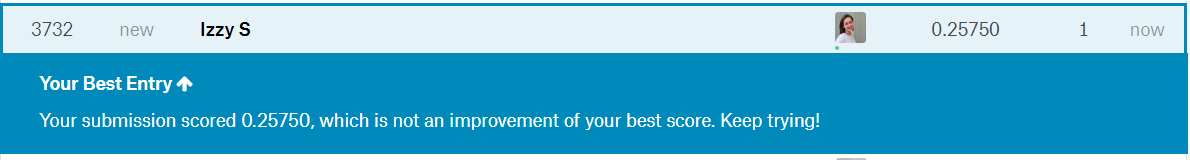

Woo! First submission! And just for kicks, I'm going to try out the k nearest neighbors regression.  It's funny that we use nearest neighbors because housing data, get it?

In [332]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, accuracy_score, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(round1scaled, targettrain, test_size=0.20, random_state=42)
reg = KNeighborsRegressor()
gridsearch = GridSearchCV(reg, {"n_neighbors": [1, 3, 5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='neg_mean_squared_error')
gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_train)
y_pred_test = gridsearch.predict(X_test)
print("Train MSE: {}\tTest MSE: {}".format(mean_squared_error(y_train, y_pred_train),
                                           mean_squared_error(y_test, y_pred_test)))

Best Params: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Train MSE: 2.3226116614917076e-06	Test MSE: 0.026954140671367744


Parameters determined, let's give it a go!

In [335]:
KNNreg = KNeighborsRegressor(n_neighbors=9, weights='distance', p=1)
KNNreg.fit(round1scaled, targettrain)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=9, p=1,
          weights='distance')

In [337]:
predicted_prices2 = np.exp(KNNreg.predict(test1scaled))

In [338]:
my_submission2 = pd.DataFrame({'Id': testdata.Id, 'SalePrice': predicted_prices})
my_submission2.to_csv('submission2.csv', index=False)

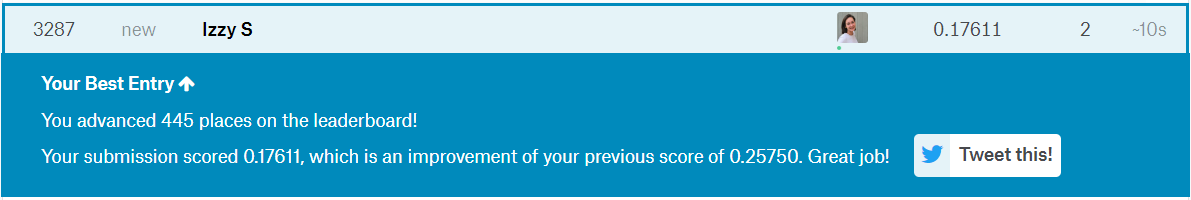

Wohoo! Improvement!